<a href="https://colab.research.google.com/github/jp7252/ML4RM/blob/main/Class_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Shapley

- Players? Game? Payout? What is the connection to machine learning predictions and interpretability? The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances. The “players” are the feature values of the instance that collaborate to receive the gain (= predict a certain value).

- Assume the following scenario: You have trained a machine learning model to predict apartment prices. For a certain apartment it predicts \$300,000 and you need to explain this prediction. The apartment has an area of 1000 sqft, is located on the 2nd floor, has a park nearby and cats are banned.
- In our apartment example, the feature values `park-nearby`, `cat-banned`, `area-1000` and `floor-2nd` worked together to achieve the prediction of \$300,000. Our goal is to explain the difference between the actual prediction (\$300,000) and the average prediction ($310,000): a difference of -\$10,000.

- We can use the following vector to represent the house with an area of 1000 sqft, is located on the 2nd floor, has a park nearby and cats are banned.
    - [park, area, cat, floor]
    - [1, 1000, 0, 2]
- We will study the features one by one but let's start with the **area** column.

- **Step 1:** Pick a random permutation of the ordering of the features
    - Eg: [cat, park, area, floor]
    - The sample we picked from the previous step becomes [0, 1, 1000, 2]

- **Step 2:** Pick a random sample from the dataset using the same ordering we picked from step 1.
- For example, the one below means that we picked a sample that is cat-friendly, no-park-nearby, 1300 sqaure footage and on the 3rd floor.
    - [cat, park, area, floor]
    - Eg: [1, 0, 1300, 3]

- **Step 3:** Form vectors $X_1$ and $X_2$. The way we do it is replace the the features on and after the one that we are focusing (square footage in this case) with the values of the random sample from step 2.
- They are like "Frankenstein Monster" made from the sample we are focusing and the random sample we picked from step 2.
- We then predict the housing price of $X_1$ and $X_2$ using our model.
    - Feature ordering: [cat, park, area, floor]
    - $X_1$ = [0, 1, 1000, **3**] => $y_1$ = $305,000
    - $X_2$ = [0, 1, **1300**, **3**] => $y_2$ = $330,000
- The marginal contribution of area (1000) in this iteration is equal to $y_1-y_2=-25,000$

- **Step 4:** Record the difference and return to step 1. Repeat many times and we can then calculate

$$SHAP(area=1000|[1, 1000, 0, 2])=E(diff)$$

- Repeat the steps 1-4 for all features values, we can find the following values:
$$SHAP(park=1|[1, 1000, 0, 2])$$
$$SHAP(cat=0|[1, 1000, 0, 2])$$
$$SHAP(floor=2|[1, 1000, 0, 2])$$

### Intuition
- An intuitive way to understand the Shapley value is that the feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction).
- The Shapley value of a feature value is the average change in the prediction that the coalition already in the room receives when the feature value joins them.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd

df = pd.read_csv("https://drive.google.com/uc?id=1Ijs6Quta_ZAd3dsKWMvI6pxaHjpXgFoU")

y = df['loan_outcome']
X = df.drop('loan_outcome', axis=1)

# One-hot encode the categorical column
X = pd.get_dummies(X)

# Impute the missing values
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1, class_weight="balanced")
logit.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, class_weight='balanced')

- Install the [SHAP](https://github.com/shap/shap) package

In [ ]:
!pip install -q shap

In [ ]:
df.head()

,loan_amnt,int_rate,home_ownership,annual_inc,term,employment_years,loan_outcome
0,12500.0,0.1727,RENT,30000.0,60.0,5.0,1
1,12000.0,0.1629,RENT,88365.0,36.0,9.0,0
2,17500.0,0.1727,MORTGAGE,45000.0,60.0,7.0,1
3,6000.0,0.1349,RENT,50000.0,36.0,5.0,0
4,18000.0,0.0790,RENT,56964.0,36.0,10.0,0


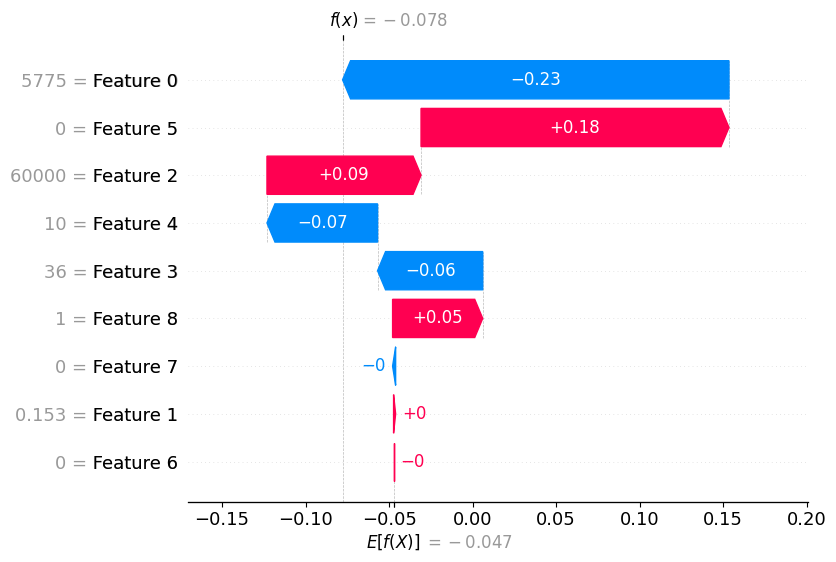

In [ ]:
import shap

# explain the model's predictions using SHAP
explainer = shap.Explainer(logit, X_train)
shap_values = explainer(X_test)

# visualize the prediction's explanation
shap.plots.waterfall(shap_values[1])

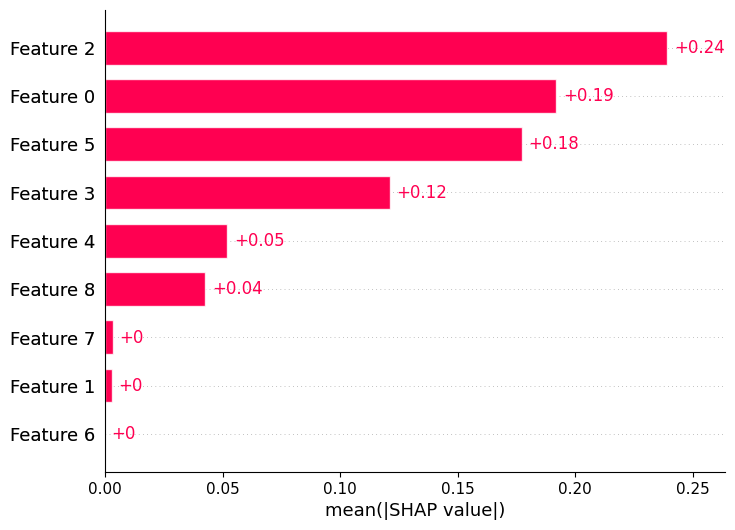

In [ ]:
shap.plots.bar(shap_values)

### Bayes' Theorem

- The core concept of Bayes' Theorem is the conditional probability. For example, rolling a fair dice, the probability we end up with a six is one-sixth. But if we only count an outcome if it's an even number (so we roll the dice again it the outcome is odd), then the probability we end up with a six is one-third. So the condition on even numbers impacts the probability we get a six.

- The definition of a conditional probability is

$$P(Y|X) = \frac{P(Y\cap X)}{P(X)}$$

- Consider the previous example, so
 - event $Y$ is that we get a six
 - event $X$ is that we get an even number (2,4, or 6)
- So the event probability $Y\cap X$ is when both $Y$ and $X$ happen, which is $P(Y\cap X)=\frac{1}{6}$. And the event $X$ is 2, 4, or 6, so $P(X)=\frac{1}{2}$. Therefore
$$P(Y|X)=\frac{\frac{1}{6}}{\frac{1}{2}}=\frac{1}{3}$$

- Consider another example of picking balls of two colors, red and black, from two boxes labeled A and B.
- There are 10 black balls and 1 red ball in box A, and 1 black ball and 10 red balls in box B.
- We randomly choose a box (with equal chance) and then pick a ball from the chosen box.
- What is the probability that we draw a red ball?

- While choosing a box, we have:
 - $P(A)=P(B)=0.5$
- If we choose A, $P(red|A)=1/11$
- If we choose B, $P(red|B)=10/11$
So the **total probability** to draw one red ball is:
$$P(red)=P(red|A)*P(A) + P(red|B)*P(B)
=\frac{1}{11}*\frac{1}{2}+\frac{10}{11}*\frac{1}{2}
=\frac{1}{2}$$

- Very often, we want to switch the event and the condition in the conditional probability. This is when we can apply the Bayes theorem:

$$P(Y|X) = \frac{P(Y\cap X)}{P(X)}=\frac{P(X|Y)*P(Y)}{P(X)}$$

- When do we want to switch the conditional probability? It's actually quite natural! Recall the iris dataset, what we want to do is to predict the species of an iris flower based on its measurement, say, the sepal length.
- We train a model to predict, for example, if the sepal length is 6 cm, how likely it is a setosa (or versicolor and virginica.) Therefore, the conditional probability that represents this is:

$$P(Setosa|sepal.length=6)$$

- If you try to investigate this conditional probability with data analysis, you will find it quite unnatural. However, for the other way around, we do have a tool for it, namely, a histogram.

$$P(sepal.length=6|Setosa)$$

- All the details aside, the Bayes' theorem can help us to connect the desired probability with the probability (density) that we do know how to estimate.

- Consider our last example of two boxes and red and black balls. Let's say we end up with a red ball, what's the probability that it's from the box of one red ball, or box A?

$$P(A|red)=\frac{P(red|A)*P(A)}{P(red)}=\frac{\frac{1}{11}*\frac{1}{2}}{\frac{1}{2}}=\frac{1}{11}$$

### Practice

Here we present a famous medical test paradox. Suppose a medical test for a disease has 90% sensitivity, meaning that 90% of the sick people test positive, and 91% specificity, meaning 9% of the healthy people are test positive. Let's further assume one percent of the population has the disease. Then if a patient tests positive, what is the probability that the patient is sick?

## Naive Bayes

- Naive Bayes is a probabilistic supervised classification method concerned with describing uncertainty.
- In a nutshell, the Naive Bayes method employs a frequentist perspective on data analysis; it uses information about prior events to estimate the probability of future events.

- Suppose you wanted to predict whether or not an incoming email message was spam:
 - With no knowledge of the incoming email, the best guess you could give is the probability that any previous email was spam (i.e., the **prior probability**).

- What if you knew the incoming email contained the word “Free”? That knowledge should theoretically change the probability of the message being spam because of dependencies among the variables:
 - The probability that the word "Free" was used in previously observed spam messages is called the **likelihood**.
 - The probability that "Free" appeared in any given message is called the **marginal likelihood**.


- By implementing Bayes' Theorem, we can compute the **posterior probability** that measures the likelihood of the new message being spam given the evidence that the email contained the word "Free":

$$P(Spam|Free)=\frac{P(Free|Spam)P(Spam)}{P(Free)}$$

- If the posterior probability is greater than 50%, then it is more likely than not that the email is spam.
- If the posterior probability is less than 50%, then it is more likely than not that the email is not spam.

- Consider the following dataset of emails:


|          |  Free  | No Free | Total  |
| -------  | -------| ------- | -------|
| Spam     | 4      | 16      | 20  |
| Not Spam | 1      | 79      | 80   |
| **Total** | 5     | 95      | 100   |

- What is the posterior probability that an email is spam given that it contains the word "Free"?

- The likelihood P(Free | spam) = 4/20 = 0.2.
- The prior P(spam) = 20/100 = 0.2.
- The marginal likelihood P(Free) = 5/100 = 0.05.
- The posterior probability P(spam | Free) = (0.2 * 0.2)/0.05 = 0.8; the probability that the message is spam given that it contains the word Free is 80%.

- The Naïve Bayes algorithm uses Bayes' Theorem in order to perform classification. It is considered **naive** because it makes a couple of unrealistic assumptions about the data at hand:
 - **All of the features in the dataset are equally important.**
 - **All of the features in the dataset are independent of one another.**
- Luckily, even though these assumptions are rarely true in real applications, the Naïve Bayes algorithm still performs quite well given assumption violations.

- Suppose we were looking at the presence of three different words when trying to classify an email as spam or not spam: W1, W2, and W3. Applying Bayes' Rule, we would have:
$$P(spam|W_1 \cap W_2 \cap W_3) = \frac{P(W_1 \cap W_2 \cap W_3|spam) \times P(spam)}{P(W_1 \cap W_2 \cap W_3)}$$


$$=\frac{P(W_1 |spam) \times P(W_2 |spam) \times P(W_3 |spam) \times P(spam)}{P(W_1) \times P(W_2) \times P(W_3)}$$

- The resulting value of this formula can be compared to the probability that the same message is not spam given the same words.
 - Whichever probability is higher dictates the group to which the email message should belong.

- Examine the structure of the sms data; two columns, one of the actual text itself and one displaying whether or not the observation is spam, "spam" for a spam and "ham" for a non-spam.  We are going to train a naive bayes model to predict whether a text message is spam.

In [ ]:
import pandas as pd
file_url = 'https://drive.google.com/uc?id=' + '1L08XOWRs5GWoVYhV81WCUVrljupirBXo'
sms = pd.read_csv(file_url)

In [ ]:
sms.sample(10)

,type,text
1206,ham,S da..al r above #
5148,ham,Plz note: if anyone calling from a mobile Co. ...
812,ham,Dude we should go sup again
1162,spam,"Do you ever notice that when you're driving, a..."
3622,ham,Did u receive my msg?
1633,ham,So can collect ur laptop?
5229,ham,A lot of this sickness thing going round. Take...
1440,ham,You need to get up. Now.
5365,ham,Cos i was out shopping wif darren jus now n i ...
5236,ham,Shuhui has bought ron's present it's a swatch ...


- Inspect the distribution of the dependent variable.

In [ ]:
sms["type"].value_counts()/sms.shape[0]

,count
type,
ham,0.865623
spam,0.134377


### Count Vectorizer

- Naive Bayes model works with the term frequency. The scikit-learn model does provide us conveient tool to extract such features, though we need to take care some details. Let's consider a simple example below:

In [ ]:
txt = [
    "Worked 100% with Python and python and Spark",
    "python worked spark 100"
]

- What `CountVectorizer` does is just count the frequency of each word. The parameters of a `CountVectorizer` specify which word to be counted:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    lowercase=True,
    stop_words="english",
)

vec.fit(txt).get_feature_names_out()

array(['100', 'python', 'spark', 'worked'], dtype=object)

- The transformed data is really the term frequencies in the format a sparse matrix. To convert a spark matrix to a regular numpy array, one could use the `toarray` method.

In [ ]:
matrix = vec.transform(txt)
matrix.todense()

matrix([[1, 2, 1, 1],
        [1, 1, 1, 1]])

- Now we are ready to transform the data for modeling.

In [ ]:
X = vec.fit_transform(sms["text"])
y = sms["type"]

In [ ]:
X.shape

(5559, 8397)

In [ ]:
X.todense()[:2]

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
type(X)

scipy.sparse._csr.csr_matrix

- Split the data to the training and test data:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

- Fit a multinomial naive bayes and a Bernoulli naive bayes, and evaluate the result.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb.score(X_test, y_test)

0.9741007194244604

### TF-IDF

- A **Term Frequency** is a count of how many times a word occurs in a given document (synonymous with bag of words). The **Inverse Document Frequency** is the the number of times a word occurs in a corpus of documents. TF-IDF goes one step further. It applies a frequency count but then penalizes it by dividing it across the appearance throughout all documents.

- One possible definition of TF-IDF is:

$$tf_{t,d} = log(1+ f_{t,d})$$

$$idf_{t,d} = log(1+\frac{N}{df_{t}})$$

$$w_{t,d} = tf_{t,d}\times idf_{t,d}$$

where N is the number of documents in the corpus

**Question:** Why is log used when calculating term frequency and inverse document frequency?

- If term frequency for word 'AI' in doc1 is 10 and doc2 is 20, we can say that doc2 is more relevant than doc1 for word 'AI'. However, if the term frequency of the same word, 'AI' for doc1 is 1 million and doc2 is 2 million, at this point, there is no much different in term of relevant anymore because they both contain a very high count for term 'AI'.

- Adding log is to **dampen** the importance of term that has a high frequency, e.g. Using log base 2, the count of 1 million will be reduced to 19.9!

- The `TfidfVectorizer` is equivalent to `CountVectorizer` followed by `TfidfTransformer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
txt = [
    "Worked 100% with Python and python and Spark",
    "python"
]
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(txt)
X.toarray()

array([[0.44610081, 0.6348088 , 0.44610081, 0.44610081],
       [0.        , 1.        , 0.        , 0.        ]])

In [ ]:
vectorizer.get_feature_names_out()

array(['100', 'python', 'spark', 'worked'], dtype=object)